In [2]:
# EXECUTE FIRST

# computational imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, KNNBasic, NormalPredictor,BaselineOnly,KNNWithMeans,KNNBaseline
from surprise import SVD, SVDpp, NMF, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import accuracy

import random
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.style.use('ggplot')

# display imports
from IPython.display import display, IFrame
from IPython.core.display import HTML

# for playing videos, customize height and width if desired
# keep a 16:9 ratio, e.g. 960 by 540, or 1280 by 720
def play_video(vid_name, w=640, h=360):
    vid_path = "https://media.uwex.edu/content/ds/ds775_r19/"
    return IFrame(vid_path + vid_name + "/index.html", width=w, height=h)

<font size=18>Week 14: Recommender Systems 2</font>

# Collaborative Filters


In [5]:
play_video('ds775_lesson14_collaborative-filters-introduction')

## Set Up

### Defining Data
In Chapter 6, Banik uses the movielens dataset to explore collaborative filtering. We're going to use what's called a "toy" dataset, which is just a very small dataset. This makes it easier to see what's happening at each step, though our predictions will be worse because we have much less data to go on.


In [13]:
movies = pd.DataFrame({'movie_id': [11,12,13,14,15],
                      'title':['Jumanji','Balto','Treasure Island', 'Pocahontas', 'The Wizard of Oz'],
                      'genres': [['adventure', 'fantasy','family'], ['family', 'animation','adventure'], ['adventure','family'], ['adventure', 'animation', 'drama', 'family'], ['adventure', 'family','fantasy']]
                      })

display(movies.head())

#generate a rating for each user/movie combination
ratings = pd.DataFrame(np.array(np.meshgrid([1, 2, 3,4,5], [11,12,13,14,15])).T.reshape(-1,2), columns=['user_id', 'movie_id'])
np.random.seed(1)
randratings = np.random.randint(1,6, ratings.shape[0])

ratings['rating'] = randratings

#we have 5 * 5 or 25 rows of data in the ratings, but we'll just look at the first 10
ratings.head(10)

,movie_id,title,genres
0,11,Jumanji,"[adventure, fantasy, family]"
1,12,Balto,"[family, animation, adventure]"
2,13,Treasure Island,"[adventure, family]"
3,14,Pocahontas,"[adventure, animation, drama, family]"
4,15,The Wizard of Oz,"[adventure, family, fantasy]"


,user_id,movie_id,rating
0,1,11,4
1,1,12,5
2,1,13,1
3,1,14,2
4,1,15,4
5,2,11,1
6,2,12,1
7,2,13,2
8,2,14,5
9,2,15,5


With the data loaded, our job is to predict the rating, given a user and a movie. We will do this as a regression problem. In some instances, we could view this as categorical data instead of numerical data, because we have discrete values from 1 to 5. But, since this is ordinal data (the order of the numbers has meaning), we'll treat it as continuous data. We want our regressor to "understand" that a mistaken rating of 1 when it should be 5 is a bigger mistake than a rating of 4 would be. Classification problems don't understand that nuance.

Let's split the data into train and test sets. Banik uses a hack here to stratify on the user. Stratifying on the user ensures that we have some of each user's ratings in both the train and the test set.

In [14]:
#Import the train_test_split function
# from sklearn.model_selection import train_test_split

#Assign X as the original ratings dataframe and y as the user_id column of ratings.
X = ratings.copy()
y = ratings['user_id']

#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=42)

Since we have such a small dataset, we can explore what's in our training and test data. You can see that every user is in both the training and test data, though not in equal measure.


In [15]:
#compare X_train to X_test
display(X_train)
display(X_test)

,user_id,movie_id,rating
1,1,12,5
20,5,11,5
22,5,13,2
8,2,14,5
5,2,11,1
17,4,13,3
24,5,15,2
10,3,11,2
6,2,12,1
9,2,15,5


,user_id,movie_id,rating
16,4,12,5
7,2,13,2
19,4,15,3
21,5,12,2
14,3,15,5
4,1,15,4
0,1,11,4


The variables y_train and y_test won't actually be used in our code. They're just used as a way to stratify the data. Typically you'd see y as the variable you're trying to predict. That's not how we're doing it here, since our X_train and X_test data are actually dataframes that contain both what we're using to make predictions (user_id and movie_id combination) and what we're predicting (rating). (It's a bit weird. We know.)

### RMSE Metric

Our metric for evaluation will be the Root Mean Squared Error. Banik builds a wrapper function around scikit-learn's mean_squared_error function, but that's unnecessary as of scikit-learn version 0.22.1. The function has a parameter we can use to tell it to return the RMSE instead of the MSE.

In [16]:
#Import the mean_squared_error function
# from sklearn.metrics import mean_squared_error

#test data
test_y_true = [3, -0.5, 2, 7]
test_y_pred = [2.5, 0.0, 2, 8]

#this returns MSE (not what we want)
print(mean_squared_error(test_y_true, test_y_pred))

#this returns the root mean squared error (and is what we want to use)
mean_squared_error(test_y_true, test_y_pred, squared=False)

0.375


0.6123724356957945

We're going to hand-code a series of models. All our models will take in a user_id and a movie_id, and attempt to predict the rating. (Generalizing this, we could say that they take in a user_id and an item_id, as movies is just one thing we could use this for.)


Let's define a baseline model. Our hand-coded baseline model always returns the MEDIAN of our ratings scale (not the median of all of our user's ratings). In other words, our baseline model is trying to be as noncommittal as possible. Later you'll see how to do a different baseline model with the Surprise package that uses a random rating based on a normal distribution. 

Let's walk through how to get the median of our scale using Numpy.

In [17]:
#explaining getting the median....
print('Our min is', np.min(ratings['rating']))
print('Our max plus one is', np.max(ratings['rating']) + 1)
print('If we do not plus one the arange, we only get our max - 1', np.arange(np.min(ratings['rating']), (np.max(ratings['rating']))))
print('If we plus it, we get the actual max', np.arange(np.min(ratings['rating']), (np.max(ratings['rating']) + 1)))

print('The median of the scale is then ', np.median(np.arange(np.min(ratings['rating']), (np.max(ratings['rating']) + 1))))

Our min is 1
Our max plus one is 6
If we do not plus one the arange, we only get our max - 1 [1 2 3 4]
If we plus it, we get the actual max [1 2 3 4 5]
The median of the scale is then  3.0


We're going to alter Banik's function so that it also accepts optional arguments. We don't need any for this function, but later we will need additional arguments and this keeps our coding consistent.

In [18]:
#first determine the median of our ratings (we could have done this by hand, but numpy does it so well... )
print(f"The median of this rating range is {np.median(np.arange(np.min(ratings['rating']), (np.max(ratings['rating']) + 1)))}")

#define a baseline model to always return the median
def baseline(user_id, movie_id, scale_median, *args):
    '''
    Parameters:
    user_id, movie_id, *args: None of which are used, but are included for consistency
    scale_median: the median of the rating scale

    Returns:
    the median of the rating scale
    '''
    return scale_median

The median of this rating range is 3.0


Next we need a way to score our model.

Here's where we diverge from Banik's approach just a bit. Instead of relying on global variables, we will explicitly pass in our data for our scoring model. Note we're again using the special parameter \*args. This tells our scoring function to accept any optional arguments we might need, and we'll pass those right along to our model.

We are also going to follow the example of the Surprise package and assume that our data has 3 columns in this order:
* the user id
* the item id
* the rating

(This means that the score method will work for any dataframe that's set up that way, regardless of the column names. It's the order that matters, not the names of the columns.)

We'll also use sklearn's built in RMSE function.

Here's the complete function.

In [19]:
#Function to compute the RMSE score obtained on the testing set by a model
def score(cf_model, X_test, *args):
    '''
    Parameters:
    cf_model: This is the model that will be used to predict ratings
    X_test: This is the data (a dataframe of user_id, item_id, rating) for which we'll predict ratings
    *args: any additional values that should be passed to the cf_model
    Returns:
    The final mean_squared_error
    '''
    
    #Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(X_test[X_test.columns[0]], X_test[X_test.columns[1]])
    
    #Predict the rating for every user-item tuple
    y_pred = np.array([cf_model(user, item, *args) for (user, item) in id_pairs])
    
    #Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test[X_test.columns[2]])

    #Return the final RMSE score
    return mean_squared_error(y_true, y_pred, squared=False)
                              
#let's test it with our baseline model
score(baseline, X_test, 3)

1.3093073414159542

## Basic Models


Everything we've done so far is just setting us up to be able to use something more than our baseline model to do some real user-based collaborative filtering. Now let's try out some basic approaches and compare them to our baseline model.

Before we can start, though, we need to do yet more data wrangling. We need a matrix that has movies as columns and users as rows, with each user's rating for that movie at the intersection. Note that although we know that every user has rated every movie, we don't have all that data in our training set, so we still end up with some NaN values.

In [20]:
#Build the ratings matrix using pivot_table function
r_matrix = X_train.pivot_table(values='rating', index='user_id', columns='movie_id')

r_matrix.head()

movie_id,11,12,13,14,15
user_id,,,,,
1,NaN,5.0,1.0,2.0,NaN
2,1.0,1.0,NaN,5.0,5.0
3,2.0,3.0,5.0,3.0,NaN
4,4.0,NaN,3.0,5.0,NaN
5,5.0,NaN,2.0,1.0,2.0


### Mean

Note that our mean function requires the ratings_matrix argument. Here's where that \*args parameter comes in. We can pass r_matrix to our score function and it gets passed along to our cf_user_mean model.

In [21]:
#User Based Collaborative Filter using Mean Ratings
def cf_mean(user_id, item_id, ratings_matrix, scale_median):
    '''
    Parameters:
    user_id: We don't use this variable, but it's passed through for consistency with other models
    item_id: The item for which we are generating predicted rating
    ratings_matrix: The matrix of ratings with items as columns and users as rows
    scale_median: The median value of the rating scale, which will be used as the default value.
    Returns:
    The mean rating
    
    '''
    #Check if item_id exists in ratings_matrix
    if item_id in ratings_matrix:
        #Compute the mean of all the ratings given to the item
        mean_rating = ratings_matrix[item_id].mean()
    
    else:
        #Default to a rating of the scale median in the absence of any information
        mean_rating = scale_median
    
    return mean_rating


Let's look at what the cf_mean() function would return for movie 15. Movie 15 has 2 ratings: [5,2]. You can see that it returns the average of the ratings, or 3.5.

In [22]:
cf_mean(0,15,r_matrix, 3)

3.5

If we use or score function to get the predicted rating for the entire matrix, we can get the RMSE.

In [23]:
#score all the test data
score(cf_mean, X_test, r_matrix, 3)

1.153411090139653

### Weighted Mean
Weighted mean is going to give more weight to the users that are more similar to each other. We'll do this using cosine similarity. Let's look at the function from the book:


$$r_{u, m}=\frac{\sum_{u^{\prime}, u^{\prime} \neq u} \operatorname{sim}\left(u, u^{\prime}\right) \cdot r_{u^{\prime}, m}}{\sum_{u^{\prime}, u^{\prime} \neq u}\left|\operatorname{sim}\left(u, u^{\prime}\right)\right|}$$


What this says is that the rating for each user-item combination will be the **dot product** of two vectors: 
* the similarity scores between this user and other users
* the ratings of other users 

and this will be divided by the sum of the similarity scores. To calculate this value, we need a cosine similarity matrix between our user's ratings.



In [24]:
#Create a dummy ratings matrix with all null values imputed to 0
r_matrix_dummy = r_matrix.copy().fillna(0)

#Compute the cosine similarity matrix using the dummy ratings matrix
cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy)

#Convert into pandas dataframe 
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.index, columns=r_matrix.index)

cosine_sim.head(10)

user_id,1,2,3,4,5
user_id,,,,,
1,1.000000,0.379777,0.692411,0.335659,0.125245
2,0.379777,1.000000,0.404557,0.568737,0.475651
3,0.692411,0.404557,1.000000,0.783880,0.575360
4,0.335659,0.568737,0.783880,1.000000,0.751860
5,0.125245,0.475651,0.575360,0.751860,1.000000


We covered this in the video, but here's a breakdown of how we'd calculate the rating for user 4 and movie 12 (2 in the video, but we updated the IDs). We'll fold this into our weighted mean function below, but we're pulling it out here just for clarity.

In [25]:
#extract the 2 vectors and calculate the dot product
u = [0.335659, 0.568737, 0.783880]
r = [5,1,3]
np.dot(u,r)

4.598672

In [26]:
#the dot product is the same as this hand-calculation, which takes the sum of the products of the 2 values at the same index in each vector
print((5*.335659) + (1*.56737) + (3*.783880) )
#the denominator is the sum of the similarity scores
print(sum(u))
#so the full rating ends up being this
print(((5*.335659) + (1*.56737) + (3*.783880))/sum(u))

4.597305
1.688276
2.7230766770362194


With the cosine similarity matrix in hand, we can set up the weighted mean function. This function needs 2 additional arguments - the rating_matrix and the cosine similarity matrix (c_sim_matrix).

In [27]:
r_matrix

movie_id,11,12,13,14,15
user_id,,,,,
1,NaN,5.0,1.0,2.0,NaN
2,1.0,1.0,NaN,5.0,5.0
3,2.0,3.0,5.0,3.0,NaN
4,4.0,NaN,3.0,5.0,NaN
5,5.0,NaN,2.0,1.0,2.0


In [28]:
#User Based Collaborative Filter using Weighted Mean Ratings
def cf_wmean(user_id, item_id, ratings_matrix, c_sim_matrix, median_rating):
    
    #Check if item_id exists in r_matrix
    if item_id in ratings_matrix:
        print(f'UserID: {user_id} - ItemID {item_id}')
        #Get the similarity scores for the user in question with every other user
        sim_scores = c_sim_matrix[user_id]

        #Get the user ratings for the item in question
        i_ratings = ratings_matrix[item_id]

        #Extract the indices containing NaN in the i_ratings series
        idx = i_ratings[i_ratings.isnull()].index


        #Drop the NaN values from the i_ratings Series
        i_ratings = i_ratings.dropna()

        #Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)

        print(f'Final calculation: np.dot({sim_scores.tolist()}, {i_ratings.tolist()})/sum({sim_scores.tolist()})' )
        #Compute the final weighted mean
        if sim_scores.sum()>0:
            wmean_rating = np.dot(sim_scores, i_ratings)/ sim_scores.sum()
        else:  # user had zero cosine similarity with other users
            wmean_rating = median_rating

    else:
        #Default to the median in the absence of any information
        wmean_rating = median_rating
    
    return wmean_rating



#we can call our score function to get the RMSE
score(cf_wmean, X_test, r_matrix, cosine_sim, 3)


UserID: 4 - ItemID 12
Final calculation: np.dot([0.33565855667130945, 0.5687367919007337, 0.783880147156683], [5.0, 1.0, 3.0])/sum([0.33565855667130945, 0.5687367919007337, 0.783880147156683])
UserID: 2 - ItemID 13
Final calculation: np.dot([0.379777262656375, 0.4045566970313675, 0.5687367919007337, 0.47565149415449404], [1.0, 5.0, 3.0, 2.0])/sum([0.379777262656375, 0.4045566970313675, 0.5687367919007337, 0.47565149415449404])
UserID: 4 - ItemID 15
Final calculation: np.dot([0.5687367919007337, 0.7518604376126321], [5.0, 2.0])/sum([0.5687367919007337, 0.7518604376126321])
UserID: 5 - ItemID 12
Final calculation: np.dot([0.12524485821702988, 0.47565149415449404, 0.575359712265399], [5.0, 1.0, 3.0])/sum([0.12524485821702988, 0.47565149415449404, 0.575359712265399])
UserID: 3 - ItemID 15
Final calculation: np.dot([0.4045566970313675, 0.575359712265399], [5.0, 2.0])/sum([0.4045566970313675, 0.575359712265399])
UserID: 1 - ItemID 15
Final calculation: np.dot([0.379777262656375, 0.1252448582

1.2892045169426132

## Model Based Approaches

All of the above models were relatively simple and straightforward calculations, even if the code to call them was a little convoluted. 

Machine learning algorithms, on the other hand, can give us a more powerful approach, with more complicated calculations. But the <a href="http://surpriselib.com/">Surprise package</a> makes the code to call them surprisingly simple.

We're providing some sample code below and a walkthrough video to introduce  you to using the surprise package:

In [6]:
play_video('ds775_lesson14_surprise-introduction')

### Baseline: Normal Predictor
Surprise includes several baseline predictors. We'll take a look at the normal predictor. The normal predictor simply predicts a random number within your rating scale, and assumes that the ratings come from a normal distribution. If you look at the histogram of our ratings below, you can see that it's unlikely that our ratings follow a normal distribution. In fact, they don't. We generated them from a discrete uniform distribution - which is a distribution in which each of the numbers is equally likely. Given what we know about our actual ratings, we would not expect the normal predictor baseline to be a good baseline for our data. But, we'll use it anyway just to give you a feel for it.

<AxesSubplot:title={'center':'Actual Ratings'}, ylabel='Frequency'>

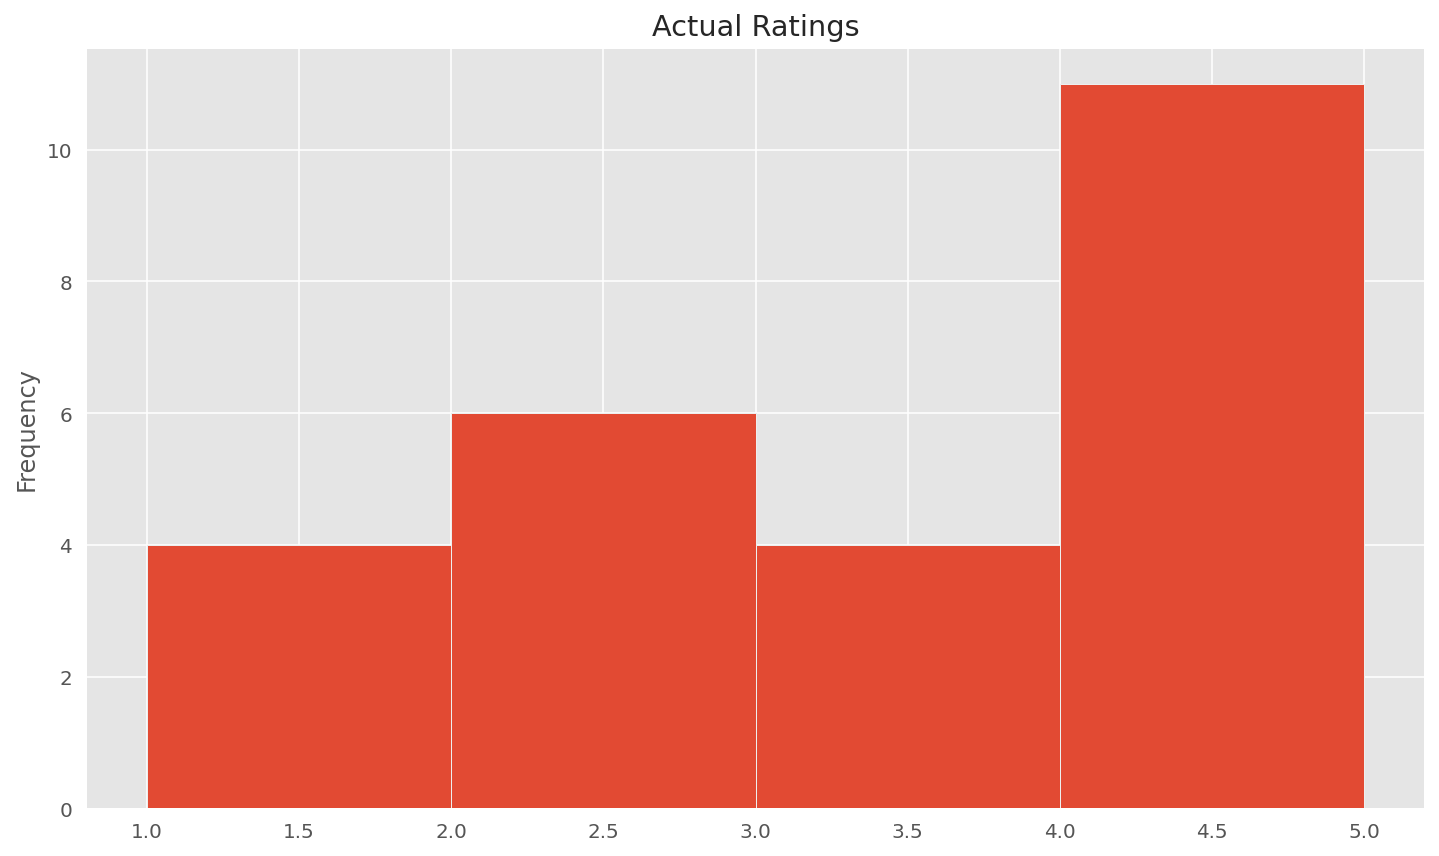

In [29]:
ratings.rating.plot(kind='hist', bins=4, title='Actual Ratings')

In [30]:
our_seed = 14

#Define a Reader object
#The Reader object helps in parsing the file or dataframe containing ratings
reader = Reader(rating_scale=(1,5)) # defaults to (0,5)

#Create the dataset to be used for building the filter
data = Dataset.load_from_df(ratings, reader)

#Define the algorithm object; in this case the normal predictor
algo = NormalPredictor() 

## apply the seeds right before cross validating, use both random and np.random
random.seed(our_seed)
np.random.seed(our_seed)
#This code cross validates (evaluates) the model
algo_cv = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
print(algo_cv)

#to extract the mean RMSE, we need to get the mean of the test_rmse values
algo_RMSE = np.mean(algo_cv['test_rmse'])
print(f'\nThe RMSE across five folds was {algo_RMSE}')

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.0239  2.4687  1.6427  1.7709  1.4042  1.8621  0.3634  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
{'test_rmse': array([2.02385476, 2.46873783, 1.64274102, 1.77092294, 1.40421843]), 'fit_time': (0.00012922286987304688, 5.054473876953125e-05, 6.580352783203125e-05, 4.38690185546875e-05, 4.1961669921875e-05), 'test_time': (5.2928924560546875e-05, 2.9802322387695312e-05, 3.0517578125e-05, 2.8371810913085938e-05, 2.7418136596679688e-05)}

The RMSE across five folds was 1.8620949953786858


In [31]:
#train on the whole dataset
trainset = data.build_full_trainset()
algo.fit(trainset)

#### Calling predictions
We can use our trained model to predict ratings for any user/item combination. Remember that for this particular algorithm, even unknown users or unknown items will get individual rating estimates, since the algorithm is just returning a random number anyway.

In [32]:
## apply the seeds right predicting, use both random and np.random
random.seed(our_seed)
np.random.seed(our_seed)
#first let's look at a single prediction for a user and item that were both in the dataset
print('Known user and item:', algo.predict(1, 11))
#this user wasn't in the dataset
print('Unknown User: ', algo.predict(0, 11))
#this item wasn't in the data set
print('Unknown item', algo.predict(1, 20))

Known user and item: user: 1          item: 11         r_ui = None   est = 5.00   {'was_impossible': False}
Unknown User:  user: 0          item: 11         r_ui = None   est = 3.32   {'was_impossible': False}
Unknown item user: 1          item: 20         r_ui = None   est = 3.46   {'was_impossible': False}


We can generate predictions for our entire dataframe by using a lambda function on each row of data. (Note that the first row of the dataframe matches our hand-coded prediction for user 1 and movie 11 above.)

In [33]:
## apply the seeds right predicting, use both random and np.random
random.seed(our_seed)
np.random.seed(our_seed)
#run some predictions
pred_df = ratings.copy() #make a copy of the ratings that we can add columns to

#get all the predictions (this could be computationally expensive and would probably only be computed occasionally)
pred_df['prediction'] = pred_df.apply(lambda x: algo.predict(x['user_id'], x['movie_id']).est, axis=1) 

pred_df

,user_id,movie_id,rating,prediction
0,1,11,4,5.000000
1,1,12,5,3.318515
2,1,13,1,3.460384
3,1,14,2,3.091737
4,1,15,4,1.000000
5,2,11,1,3.416534
6,2,12,1,1.000000
7,2,13,2,3.515960
8,2,14,5,2.364555
9,2,15,5,4.823174


### K Nearest Neighbors

When Banik looked at demographics, he was using explicit data to determine what makes people "similar" and assuming that if they were similar in that respect, their taste in movies would also be similar as well. That might be a faulty assumption. Gender, occupation, or other simple characteristics may not have any bearing on how people rate movies. But, there might be some underlying trends in the data that do result in commonalities in ratings.

K Nearest Neighbors tries to uncover these commonalities by training a model on some data and identifying clusters of users of users that are "near" one another.

Specifically, what this algorithm does is:
- Find the k-nearest neighbors that have rated movie m
- Outputs the average rating of the k users for the movie m

The <a href="https://surprise.readthedocs.io/en/stable/knn_inspired.html">documentation for KNNBasic</a> goes over all the parameters you can set when you're setting up the algorithm.

Note that in this toy set, since we only have a handful of neighbors, we will need to decrease the number of neighbors (k) that the algorithm takes into consideration. Otherwise, we'll just be getting the mean of all the considered ratings in each fold.

In [34]:
our_seed = 14

#Define a Reader object
#The Reader object helps in parsing the file or dataframe containing ratings
reader = Reader(rating_scale=(1,5)) # defaults to (0,5)

#Create the dataset to be used for building the filter
data = Dataset.load_from_df(ratings, reader)

#Define the algorithm object; in this case kNN
knn = KNNBasic(k=3, verbose=False) #the default for k is 40, we're also setting verbose to False to supress messages

## apply the seeds right before cross validating, use both random and np.random
random.seed(our_seed)
np.random.seed(our_seed)
#This code cross validates (evaluates) the model
knn_cv = cross_validate(knn, data, measures=['RMSE'], cv=5, verbose=True)
print(knn_cv)

#to extract the mean RMSE, we need to get the mean of the test_rmse values
knn_RMSE = np.mean(knn_cv['test_rmse'])
print(f'\nThe RMSE across five folds was {knn_RMSE}')

Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4385  2.6866  2.1752  1.5797  2.2290  2.0218  0.4570  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
{'test_rmse': array([1.43851143, 2.6866473 , 2.17523353, 1.57965233, 2.22902989]), 'fit_time': (5.888938903808594e-05, 2.4318695068359375e-05, 3.123283386230469e-05, 2.4080276489257812e-05, 3.266334533691406e-05), 'test_time': (8.749961853027344e-05, 9.679794311523438e-05, 8.726119995117188e-05, 8.606910705566406e-05, 4.9114227294921875e-05)}

The RMSE across five folds was 2.021814896489965


Interestingly, our RMSE for the K-nearest neighbors algorithm is actually worse than our normal predictor. This is most likely because we have a tiny dataset, or we're using the wrong k value for this data.

We can use grid search to identify the best k for this set of data. We'll set up this grid search to get an unbiased accuracy metric.

In [35]:
#Define a Reader object
#The Reader object helps in parsing the file or dataframe containing ratings
reader = Reader(rating_scale=(1,5)) # defaults to (0,5)


#Create the dataset to be used for building the filter
data = Dataset.load_from_df(ratings, reader)

#get the raw ratings
raw_ratings = data.raw_ratings

# shuffle ratings - set the seed here for homework
random.seed(our_seed)
np.random.seed(our_seed)
random.shuffle(raw_ratings)

#A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

# Select your best algo with grid search.
print('Grid Search...')
param_grid = {'k': [3,5], 'min_k': [1,3]} #this will all combinations of max k of 3 and 5 and min k of 1 and 3
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

knn_gs_algo = grid_search.best_estimator['rmse']


# retrain on the whole set A
trainset = data.build_full_trainset()
knn_gs_algo.fit(trainset)

# Compute biased accuracy on A 
predictions = knn_gs_algo.test(trainset.build_testset())
print(f'Biased accuracy on A = {accuracy.rmse(predictions)}')


# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = knn_gs_algo.test(testset)
print(f'Unbiased accuracy on B = {accuracy.rmse(predictions)}')


Grid Search...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4576
Biased accuracy on A = 

In [36]:
#we can see what our best parameters were
grid_search.best_params['rmse']

{'k': 3, 'min_k': 3}

Using the grid search, we were able to get a better RMSE. Extracting the best parameters shows us that the best combination of parameters was a max k of 3 and a min k of three. By default, KNNBasic uses a min k of 1, so our grid search found that always including 3 neighbors gave a better result than sometimes including fewer than 3 neighbors.


If we wanted to use this model for predictions, we'd want to retrain the model, using the best parameters, on all of our available data. We can do that by setting the data.raw_ratings back to the complete raw ratings, setting up a full trainset, instantiating our model with the best params, and fitting it on the full trainset.

In [37]:
#set our seeds again
random.seed(our_seed)
np.random.seed(our_seed)

#reset the data.raw_ratings to 100% of the data
data.raw_ratings = raw_ratings

#build a trainset
trainset = data.build_full_trainset()

#build the algorithm with our best parameters
knn_gs_algo = grid_search.best_estimator['rmse']

#fit to the data
knn_gs_algo.fit(trainset)

#predict user 1, movie 11
knn_gs_algo.predict(1, 11)

Computing the msd similarity matrix...
Done computing similarity matrix.


Prediction(uid=1, iid=11, r_ui=None, est=4.158597662771285, details={'actual_k': 3, 'was_impossible': False})

### Singular-value Decomposition (SVD)

The theory behind SVD is covered in Banik's book. The very high-level concept is that it's a method that allows you to reduce the dimensions of a sparse matrix and "fill in the blanks" with predictions. Under the hood, the algorithm uses stochastic gradient descent to attempt to minimize errors. We don't expect you to understand all the intricacies. We would like you to understand a couple of the hyperparameters you can tune, which are some of the same hyperparameters in every stochastic gradient descent algorithm.

* n_epochs: this is the number of times the minimization steps are performed. The higher the number of times, the longer the algorithm will work to find the minimum error. The default is 20.
* learning rate: this is a number that determines how much to change the model each iteration. Think of it as how big of a step the model takes in each iteration. Too large and you may never find your minimum. Too small and your model will be very slow and could get stuck in a local minimum. The default is .005.
* regularization: this is a penalty term applied to prevent model overfitting. The default is .02.

We won't demonstrate using these hyperparameters in the lesson, but you'll need them for the homework. Functionally, you'd use them the same way we used k and min_k with the basicKNN algorithm.

The code to do simple cross validation with SVD itself is extremely simple, once you've already got a suprise data object set up. Read the <a href="https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD">full documentation</a> if you're curious.

In [38]:
#Define the SVD algorithm object
svd = SVD()
## apply the seeds right before cross validating, use both random and np.random
random.seed(our_seed)
np.random.seed(our_seed)
#Evaluate the performance in terms of RMSE
svd_cv = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)
#to extract the mean RMSE, we need to get the mean of the test_rmse values
svd_RMSE = np.mean(svd_cv['test_rmse'])
print(f'\nThe RMSE across five folds was {svd_RMSE}')

#train on the whole dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7165  1.2531  1.9141  1.7461  1.1622  1.5584  0.2956  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    

The RMSE across five folds was 1.55841375329772


# Hybrid Recommenders

Hybrid recommenders are probably the most common recommenders you'll see in the real world, and there are many approaches to building hybrid recommenders. Banik specifically walks through a one type of recommender that combines a content-based recommender with a collaborative filter. This is a relatively simplistic hybrid recommender, but it's a good place to start, since it combines the strengths of two different recommender types. 

As you might guess, we have some suggested updates to his code. All that work you did last week to set up functions is really going to help you this week. Let's pull in the functions we used last week.


In [39]:
def fetchSimilarityMatrix(df, soupCol, vectorizer, vectorType='Tfidf'):
    '''
    Parameters
    df: the dataframe containing a soup column to tranform
    soupCol: The string title of the soup column
    vectorizer: an initialized vectorizer, with all pre-processing you desire
    vectorType: 'Tfidf' or 'Count' - representing the type of vectorizer you used.

    Returns
    Sparse Similarity Matrix
    '''

    # make sure the soup has no NaN
    df[soupCol] = df[soupCol].fillna('')
    nmatrix = vectorizer.fit_transform(df[soupCol])

    #apply the appropriate vectorizer
    if(vectorType=='Tfidf'):
        print('Using Linear Kernel (Tfidf)')
        sim =linear_kernel(nmatrix, nmatrix)
    else:
        print('Using Cosine_similarity')
        sim = cosine_similarity(nmatrix, nmatrix)
    return(sim)

def content_recommender(df, seed, seedCol, sim_matrix,  topN=5): 
    #get the indices based off the seedCol
    indices = pd.Series(df.index, index=df[seedCol]).drop_duplicates()
    
    # Obtain the index of the item that matches our seed
    idx = indices[seed]
    
    # Get the pairwsie similarity scores of all items and convert to tuples
    sim_scores = list(enumerate(sim_matrix[idx]))
    
    #delete the item that was passed in
    del sim_scores[idx]
    
    # Sort the items based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top-n most similar items.
    sim_scores = sim_scores[:topN]
    
    # Get the item indices
    item_indices = [i[0] for i in sim_scores]
    
    # Return the topN most similar items
    return df.iloc[item_indices].copy()

The first thing we need to do is to decide which data to use for our content recommender. Since we're dealing with a toy dataset anyway, let's keep this simple and just use the genres as our soup. All we'll need to do to create our soup columns is to join the genres into a string. We'll use a simple count vectorizer with 'english' stopwords and no restriction on the max number of features.

In [40]:
#make a soup from genres
movies['soup'] = movies['genres'].apply(lambda x: ' '.join(x))

#set up a count vectorizer
count = CountVectorizer(lowercase=True, stop_words='english')

#fetch our similarity matrix
sim = fetchSimilarityMatrix(movies, 'soup', count, 'Count')

#display it
pd.DataFrame(sim, index=movies['title'], columns=movies['title'])

Using Cosine_similarity


title,Jumanji,Balto,Treasure Island,Pocahontas,The Wizard of Oz
title,,,,,
Jumanji,1.000000,0.666667,0.816497,0.577350,1.000000
Balto,0.666667,1.000000,0.816497,0.866025,0.666667
Treasure Island,0.816497,0.816497,1.000000,0.707107,0.816497
Pocahontas,0.577350,0.866025,0.707107,1.000000,0.577350
The Wizard of Oz,1.000000,0.666667,0.816497,0.577350,1.000000


With our similarity matrix in hand, we can fetch our most similar movies. Let's fetch the 3 most similar movies to Jumanji. Since we have such a small dataset, that means we're only eliminating one. If you look at the dataframe above, can you predict which one will be eliminated?

In [41]:
results = content_recommender(movies, 'Jumanji', 'title', sim, 3)
results

,movie_id,title,genres,soup
4,15,The Wizard of Oz,"[adventure, family, fantasy]",adventure family fantasy
2,13,Treasure Island,"[adventure, family]",adventure family
1,12,Balto,"[family, animation, adventure]",family animation adventure


We already have a variety of trained algorithms we could use to predict how a certain user would rate these movies. Let's add a prediction for user 1 to our results dataframe using our trained knn_gs_algo, and sort in descending order by those predictions

In [42]:
results['est_rating'] = results.apply(lambda x: knn_gs_algo.predict(1, x['movie_id']).est, axis=1)
results.sort_values('est_rating', ascending=False)


,movie_id,title,genres,soup,est_rating
1,12,Balto,"[family, animation, adventure]",family animation adventure,4.524207
4,15,The Wizard of Oz,"[adventure, family, fantasy]",adventure family fantasy,3.507513
2,13,Treasure Island,"[adventure, family]",adventure family,1.509182


Given this data, we'd want to recommend 'Balto' or 'The Wizard of Oz.' Would we want to recommend 'Treasure Island?' It's similar to 'Jumanji,' but our recommender estimates we wouldn't rate it very highly.

## Putting it together
Let's wrap up what we did above in a nice hybrid function. There's multiple ways we could do this. We'll show you one of them. In this approach, we're doing our content recommender outside our hybrid and passing in the resulting recommendations. In the homework, we'll ask you to pass in all the parameters needed to run your content recommender inside your hybrid function. 


In [43]:
def hybrid(user,contentRecs, predCol,algorithm, N):
    '''
    Parameters
    user: the user for whom we are making predictions
    contentRecs: the dataframe of items (already limited by whatever content recommender you've used)
    predCol: the column in contentRecs on which we'll be making predictions (the itemID column)
    algorithm: a trained Surprise model that will be used for making predictions
    N: the number of predictions to return
    Returns
    a pandas dataframe containing everything in the contentRecs dataframe, plus the estimated rating for the user requested
    '''
    
    #generated predicted ratings
    contentRecs['est_rating'] = contentRecs.apply(lambda x: algorithm.predict(user, x[predCol]).est, axis=1)
    #sort the results
    contentRecs = contentRecs.sort_values('est_rating', ascending=False)

    #return the finalN number of results
    return contentRecs.head(N)

#here we're calling it with user 1, the results from our prior content_recommender function call, the 'movie_id' is the column we want ratings for using the 'knn_gs_algo' model and returning 2 recommendations
hybrid(1, results, 'movie_id', knn_gs_algo, 2)

,movie_id,title,genres,soup,est_rating
1,12,Balto,"[family, animation, adventure]",family animation adventure,4.524207
4,15,The Wizard of Oz,"[adventure, family, fantasy]",adventure family fantasy,3.507513


# Self Assessment
Follow the examples and use the code files provided from from chapters 5-7 in **Hands-On Recommendation Systems with Python** by Rounak Banik to do the following self-assessment exercises.  

The self-assessments in this lesson will be using a subset of data from the Book-Crossing dataset.  Click <a href = http://www2.informatik.uni-freiburg.de/~cziegler/BX/> here </a> for more details on the Book-Crossing dataset.

## User-Based Collaborative Filter

### *Self-Assessment: Setting up the File*

The file **BX-Book-Ratings-3000.csv** (found in the presentation download for this lesson) is loaded here for you, though you may need to change the file path unless you create the same folder structure. Note that book ratings have been adjusted so the scale goes from 1 to 11.   

Run the cell below it to load the file and then do the following:

* display the first 5 lines of the data (get familiar with the data frame)
* calculate the mean book rating for all books (just to get an idea)
* split the data set so that 70\% of a users ratings are in the training set and 30\% are in the testing set

In [57]:
# load the data
import pandas as pd
bx = pd.read_csv('./data/BX-Book-Ratings-3000.csv')

In [58]:
# enter your code here

### *Self-Assessment: Baseline RMSE to Assess Model Performance*

Build a baseline model that assigns a neutral rating and compute the RMSE of these simple "predictions" using the testing set. Make sure to make this model accept \*args so that it aligns with more complicated models.

A neutral rating would occur at the midpoint of the rating scale.  Calculate the median of the rating scale to determine what the baseline model should return.

In [59]:
# enter your code here

### *Self-Assessment: Weighted Mean User-Based Filter*

Build a ratings matrix from the data frame of users, books, and ratings and build a user-based collaborative filtering model that weights mean rank using cosine similarity among users.  Fit the model on the training set and compute the RMSE for this model using the test set and compare it to the RMSE of the baseline model.  Is it better than baseline?  (*i.e.* is the RMSE smaller?)

In [60]:
# enter your code here

### *Self-Assessment: Weighted Mean Item-Based Filter*

Create a new ratings matrix from the data frame of users, books, and ratings with the rows defined by books (*i.e.* items) and columns defined by users to build an item-based collaborative filtering model that weights mean rank using cosine similarity among items.  Fit the model on the training set and compute the RMSE for this model on the test and compare it to the RMSEs of the baseline and weighted mean user-based models.  Is this one better than baseline?

In [61]:
# enter your code here

### *Self-Assessment: kNN-Based Collaborative Filter*

Use the *surprise* library in Python to build an kNNBasic collaborative filtering model for the BX-Books ratings.  Compute the average RMSE for this model from 5 cross-validations, using a k of 5. Do not tune the hyperparameters. Compare it to the RMSEs of the baseline, weighted mean user-based, and weighted mean item-based models previously obtained. Use a seed of 1.




In [62]:
# enter your code here

### *Self-Assessment: KNNBasic Item-based Collaborative Filter*
Surprise makes it easy to switch between user-based and item-based collaborative filtering. By default it's always using user-based. To switch it to item-based, you need to set the sim_options dictionary key "user_based" to False

Set up a sim_options dictionary that sets user_based to false and k to 5. Use those sim_options to instantiate your KNNBasic algorithm and run 5-fold cross validation on all the data.

Consult <a href="https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration">the documentation for examples</a>.


In [63]:
#enter your code here

### *Self-Assessment: Hybrid Recommender*

Another kind of hybrid recommender system is one which uses multiple recommenders, but weights the recommendations of each recommender to achieve a final set of recommendations. For this self assessment, you're going to write a function that takes a ratings dataframe, a userid, 2 trained Surprise models, a weight (that's less than 1 - meaning it will be a decimal representing the percent of confidence we have in that algorithm) for your first recommender, and a number indicating how many recommendations to return. 

Your recommender should do the following:
* generate a dataframe of unique items from the ratings dataframe (there are multiple ways to accomplish this)
* generate predicted rating for each combination of passed in userid and item using the first Surprise model (add a column to your unique items dataframe)
* generate predicted rating for each combination of passed in userid and item using the second Surprise model (add another column to your unique items dataframe)
* generate a final rating that multiplies the predicted rating of each model by their weight and adds them. (Use a lambda function and create a finalRating column.) Note that your weights should add up to 1, so your weight for your second recommender will be 1-the weight for your first recommender.
* sort your unique items by the final rating and return the top N recommendations with their ratings.

To test your function:
* Use userid 31315
* Use an item-based KNNBasic algorithm. Do not set k (just let it use the default). Train it on the complete dataset (do not cross validate).
* Use an SVD algorithm with all the default parameters. Train it on the entire dataset. (Do not cross-validate.)
* Weight the KNNBasic algorithm with .6. 
* Return the top 10 book recommendations.


In [64]:
# enter your code here